In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,  LabelEncoder, OrdinalEncoder 
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
from xgboost import XGBClassifier


from sklearn.metrics import accuracy_score, classification_report, confusion_matrix


from scipy.stats import pointbiserialr


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from collections import Counter



import joblib

from datetime import datetime


# 0- Importation du fichier merge preclean

In [2]:
df = pd.read_parquet(r'C:\Users\dimle\Documents\clone_repo\preventive_maintenance\data_preclean_avion_full_compo.parquet')

In [3]:
pd.set_option("display.max_columns", None)

In [4]:
df.head(3)

,aero_,measure_day_,usure_nouvelle_max_Ailerons,usure_nouvelle_max_Autopilote,usure_nouvelle_max_Détecteurs_de_fumée,usure_nouvelle_max_Empennage,usure_nouvelle_max_Flaps,usure_nouvelle_max_Freins,usure_nouvelle_max_Gouvernail_de_direction,usure_nouvelle_max_Générateur_électrique,usure_nouvelle_max_Hublots,usure_nouvelle_max_Ordinateur_de_vol,usure_nouvelle_max_Porte_cargo,usure_nouvelle_max_Portes_passagers,usure_nouvelle_max_Radar_météorologique,usure_nouvelle_max_Réacteur_droit,usure_nouvelle_max_Réacteur_gauche,usure_nouvelle_max_Siège_copilote,usure_nouvelle_max_Siège_pilote,usure_nouvelle_max_Spoilers,usure_nouvelle_max_Système_anti-givre,usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_max_Système_d'annonce_publique,usure_nouvelle_max_Système_d'approvisionnement_en_eau,usure_nouvelle_max_Système_d'atterrissage_automatique,usure_nouvelle_max_Système_d'extinction_d'incendie,usure_nouvelle_max_Système_de_commande_des_gaz,usure_nouvelle_max_Système_de_communication_radio,usure_nouvelle_max_Système_de_conditionnement_d'air,usure_nouvelle_max_Système_de_contrôle_de_vol,usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_max_Système_de_divertissement_en_vol,usure_nouvelle_max_Système_de_gestion_de_carburant,usure_nouvelle_max_Système_de_gestion_électrique,usure_nouvelle_max_Système_de_navigation,usure_nouvelle_max_Système_de_pressurisation,usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_max_Système_hydraulique_principal,usure_nouvelle_max_Systèmes_d'oxygène_d'urgence,usure_nouvelle_max_Toilettes,usure_nouvelle_max_Train_d'atterrissage_avant,usure_nouvelle_max_Train_d'atterrissage_principal,usure_nouvelle_max_Unité_de_gestion_de_l'air,usure_nouvelle_max_Éclairage_d'urgence,usure_nouvelle_max_Éclairage_de_cabine,usure_nouvelle_max_Éclairage_de_la_cabine,usure_nouvelle_mean_Ailerons,usure_nouvelle_mean_Autopilote,usure_nouvelle_mean_Détecteurs_de_fumée,usure_nouvelle_mean_Empennage,usure_nouvelle_mean_Flaps,usure_nouvelle_mean_Freins,usure_nouvelle_mean_Gouvernail_de_direction,usure_nouvelle_mean_Générateur_électrique,usure_nouvelle_mean_Hublots,usure_nouvelle_mean_Ordinateur_de_vol,usure_nouvelle_mean_Porte_cargo,usure_nouvelle_mean_Portes_passagers,usure_nouvelle_mean_Radar_météorologique,usure_nouvelle_mean_Réacteur_droit,usure_nouvelle_mean_Réacteur_gauche,usure_nouvelle_mean_Siège_copilote,usure_nouvelle_mean_Siège_pilote,usure_nouvelle_mean_Spoilers,usure_nouvelle_mean_Système_anti-givre,usure_nouvelle_mean_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_mean_Système_d'annonce_publique,usure_nouvelle_mean_Système_d'approvisionnement_en_eau,usure_nouvelle_mean_Système_d'atterrissage_automatique,usure_nouvelle_mean_Système_d'extinction_d'incendie,usure_nouvelle_mean_Système_de_commande_des_gaz,usure_nouvelle_mean_Système_de_communication_radio,usure_nouvelle_mean_Système_de_conditionnement_d'air,usure_nouvelle_mean_Système_de_contrôle_de_vol,usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_mean_Système_de_divertissement_en_vol,usure_nouvelle_mean_Système_de_gestion_de_carburant,usure_nouvelle_mean_Système_de_gestion_électrique,usure_nouvelle_mean_Système_de_navigation,usure_nouvelle_mean_Système_de_pressurisation,usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_mean_Système_hydraulique_principal,usure_nouvelle_mean_Systèmes_d'oxygène_d'urgence,usure_nouvelle_mean_Toilettes,usure_nouvelle_mean_Train_d'atterrissage_avant,usure_nouvelle_mean_Train_d'atterrissage_principal,usure_nouvelle_mean_Unité_de_gestion_de_l'air,usure_nouvelle_mean_Éclairage_d'urgence,usure_nouvelle_mean_Éclairage_de_cabine,usure_nouvelle_mean_Éclairage_de_la_cabine,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,debut_service,last_maint,en_maintenance,measure_day,temps_de_vol_cumule,etat_voyant_suivant
0,A320_1884,2024-06-04,24.424320,30.542460,6.841880,36.802480,17.114500,17.502700,40.335740,30.028880,28

# 1- clean du dataset pour le ML

In [5]:
df['measure_day_'] = pd.to_datetime(df['measure_day_'])
df['last_maint'] = pd.to_datetime(df['last_maint'])

In [6]:
# ajouter la colonne nb de jour depuis la derniere maintenande
# measure_day_ - last_maint

df['nb_jours_maint'] = df.apply(lambda x: x['measure_day_'] - x['last_maint'], axis=1)

In [7]:
# ajout du nombre de jour depuis la mise en service à jour_vol
df['nb_jours_service'] = df.apply(lambda x: x['measure_day_'] - x['debut_service'], axis=1)

In [8]:
# suppression des colonnes date inutile
df = df.drop(columns=['measure_day', 'last_maint', 'debut_service', 'etat_voyant_suivant'])

In [9]:
# modification du type de variable pour les ecarts de date (passage en integer depuis un timedelta64[ns] en jour)
df['nb_jours_maint'] = df['nb_jours_maint'].dt.days
df['nb_jours_service'] = df['nb_jours_service'].dt.days

In [10]:
df.head(2)

,aero_,measure_day_,usure_nouvelle_max_Ailerons,usure_nouvelle_max_Autopilote,usure_nouvelle_max_Détecteurs_de_fumée,usure_nouvelle_max_Empennage,usure_nouvelle_max_Flaps,usure_nouvelle_max_Freins,usure_nouvelle_max_Gouvernail_de_direction,usure_nouvelle_max_Générateur_électrique,usure_nouvelle_max_Hublots,usure_nouvelle_max_Ordinateur_de_vol,usure_nouvelle_max_Porte_cargo,usure_nouvelle_max_Portes_passagers,usure_nouvelle_max_Radar_météorologique,usure_nouvelle_max_Réacteur_droit,usure_nouvelle_max_Réacteur_gauche,usure_nouvelle_max_Siège_copilote,usure_nouvelle_max_Siège_pilote,usure_nouvelle_max_Spoilers,usure_nouvelle_max_Système_anti-givre,usure_nouvelle_max_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_max_Système_d'annonce_publique,usure_nouvelle_max_Système_d'approvisionnement_en_eau,usure_nouvelle_max_Système_d'atterrissage_automatique,usure_nouvelle_max_Système_d'extinction_d'incendie,usure_nouvelle_max_Système_de_commande_des_gaz,usure_nouvelle_max_Système_de_communication_radio,usure_nouvelle_max_Système_de_conditionnement_d'air,usure_nouvelle_max_Système_de_contrôle_de_vol,usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_max_Système_de_divertissement_en_vol,usure_nouvelle_max_Système_de_gestion_de_carburant,usure_nouvelle_max_Système_de_gestion_électrique,usure_nouvelle_max_Système_de_navigation,usure_nouvelle_max_Système_de_pressurisation,usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_max_Système_hydraulique_principal,usure_nouvelle_max_Systèmes_d'oxygène_d'urgence,usure_nouvelle_max_Toilettes,usure_nouvelle_max_Train_d'atterrissage_avant,usure_nouvelle_max_Train_d'atterrissage_principal,usure_nouvelle_max_Unité_de_gestion_de_l'air,usure_nouvelle_max_Éclairage_d'urgence,usure_nouvelle_max_Éclairage_de_cabine,usure_nouvelle_max_Éclairage_de_la_cabine,usure_nouvelle_mean_Ailerons,usure_nouvelle_mean_Autopilote,usure_nouvelle_mean_Détecteurs_de_fumée,usure_nouvelle_mean_Empennage,usure_nouvelle_mean_Flaps,usure_nouvelle_mean_Freins,usure_nouvelle_mean_Gouvernail_de_direction,usure_nouvelle_mean_Générateur_électrique,usure_nouvelle_mean_Hublots,usure_nouvelle_mean_Ordinateur_de_vol,usure_nouvelle_mean_Porte_cargo,usure_nouvelle_mean_Portes_passagers,usure_nouvelle_mean_Radar_météorologique,usure_nouvelle_mean_Réacteur_droit,usure_nouvelle_mean_Réacteur_gauche,usure_nouvelle_mean_Siège_copilote,usure_nouvelle_mean_Siège_pilote,usure_nouvelle_mean_Spoilers,usure_nouvelle_mean_Système_anti-givre,usure_nouvelle_mean_Système_d'alerte_de_proximité_au_sol_(GPWS),usure_nouvelle_mean_Système_d'annonce_publique,usure_nouvelle_mean_Système_d'approvisionnement_en_eau,usure_nouvelle_mean_Système_d'atterrissage_automatique,usure_nouvelle_mean_Système_d'extinction_d'incendie,usure_nouvelle_mean_Système_de_commande_des_gaz,usure_nouvelle_mean_Système_de_communication_radio,usure_nouvelle_mean_Système_de_conditionnement_d'air,usure_nouvelle_mean_Système_de_contrôle_de_vol,usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol,usure_nouvelle_mean_Système_de_divertissement_en_vol,usure_nouvelle_mean_Système_de_gestion_de_carburant,usure_nouvelle_mean_Système_de_gestion_électrique,usure_nouvelle_mean_Système_de_navigation,usure_nouvelle_mean_Système_de_pressurisation,usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien,usure_nouvelle_mean_Système_hydraulique_principal,usure_nouvelle_mean_Systèmes_d'oxygène_d'urgence,usure_nouvelle_mean_Toilettes,usure_nouvelle_mean_Train_d'atterrissage_avant,usure_nouvelle_mean_Train_d'atterrissage_principal,usure_nouvelle_mean_Unité_de_gestion_de_l'air,usure_nouvelle_mean_Éclairage_d'urgence,usure_nouvelle_mean_Éclairage_de_cabine,usure_nouvelle_mean_Éclairage_de_la_cabine,time_en_air,etat_voyant,temp,pressure,vibrations,type_model,en_maintenance,temps_de_vol_cumule,nb_jours_maint,nb_jours_service
0,A320_1884,2024-06-04,24.424320,30.542460,6.841880,36.802480,17.11450,17.50270,40.335740,30.028880,28.256040,36.529380,28.500460

In [11]:
df.isna().sum()

aero_                                     0
measure_day_                              0
usure_nouvelle_max_Ailerons               0
usure_nouvelle_max_Autopilote             0
usure_nouvelle_max_Détecteurs_de_fumée    0
                                         ..
type_model                                0
en_maintenance                            0
temps_de_vol_cumule                       0
nb_jours_maint                            0
nb_jours_service                          0
Length: 100, dtype: int64

In [12]:
df.describe().T

,count,mean,min,25%,50%,75%,max,std
measure_day_,5216,2024-06-29 22:09:17.668711680,2024-06-04 00:00:00,2024-06-17 00:00:00,2024-06-30 00:00:00,2024-07-14 00:00:00,2024-07-25 00:00:00,NaN
usure_nouvelle_max_Ailerons,5216.0,34.768307,1.479212,18.842008,33.160028,49.847288,74.7767,18.272441
usure_nouvelle_max_Autopilote,5216.0,39.678474,1.184492,24.92518,38.988426,54.614912,79.259019,17.897764
usure_nouvelle_max_Détecteurs_de_fumée,5216.0,40.281875,0.619696,25.950399,40.970994,55.882741,82.491952,17.759
usure_nouvelle_max_Empennage,5216.0,39.241009,1.868096,25.000466,39.493128,53.440356,81.82632,17.432163
...,...,...,...,...,...,...,...,...
pressure,5216.0,951.009701,757.3,917.2,951.9,985.1,1109.5,49.429679
vibrations,5216.0,2.520953,0.001847,1.272012,2.530016,3.773474,4.999276,1.451211
temps_de_vol_cumule,5216.0,23.408723,0.6,9.1,18.4,32.725,110.8,18.52127
nb_jours_maint,5216.0,80.061158,2.0,25.0,47.0,131.0,387.0,72.992404


# 1.bis- Visualisation des data 

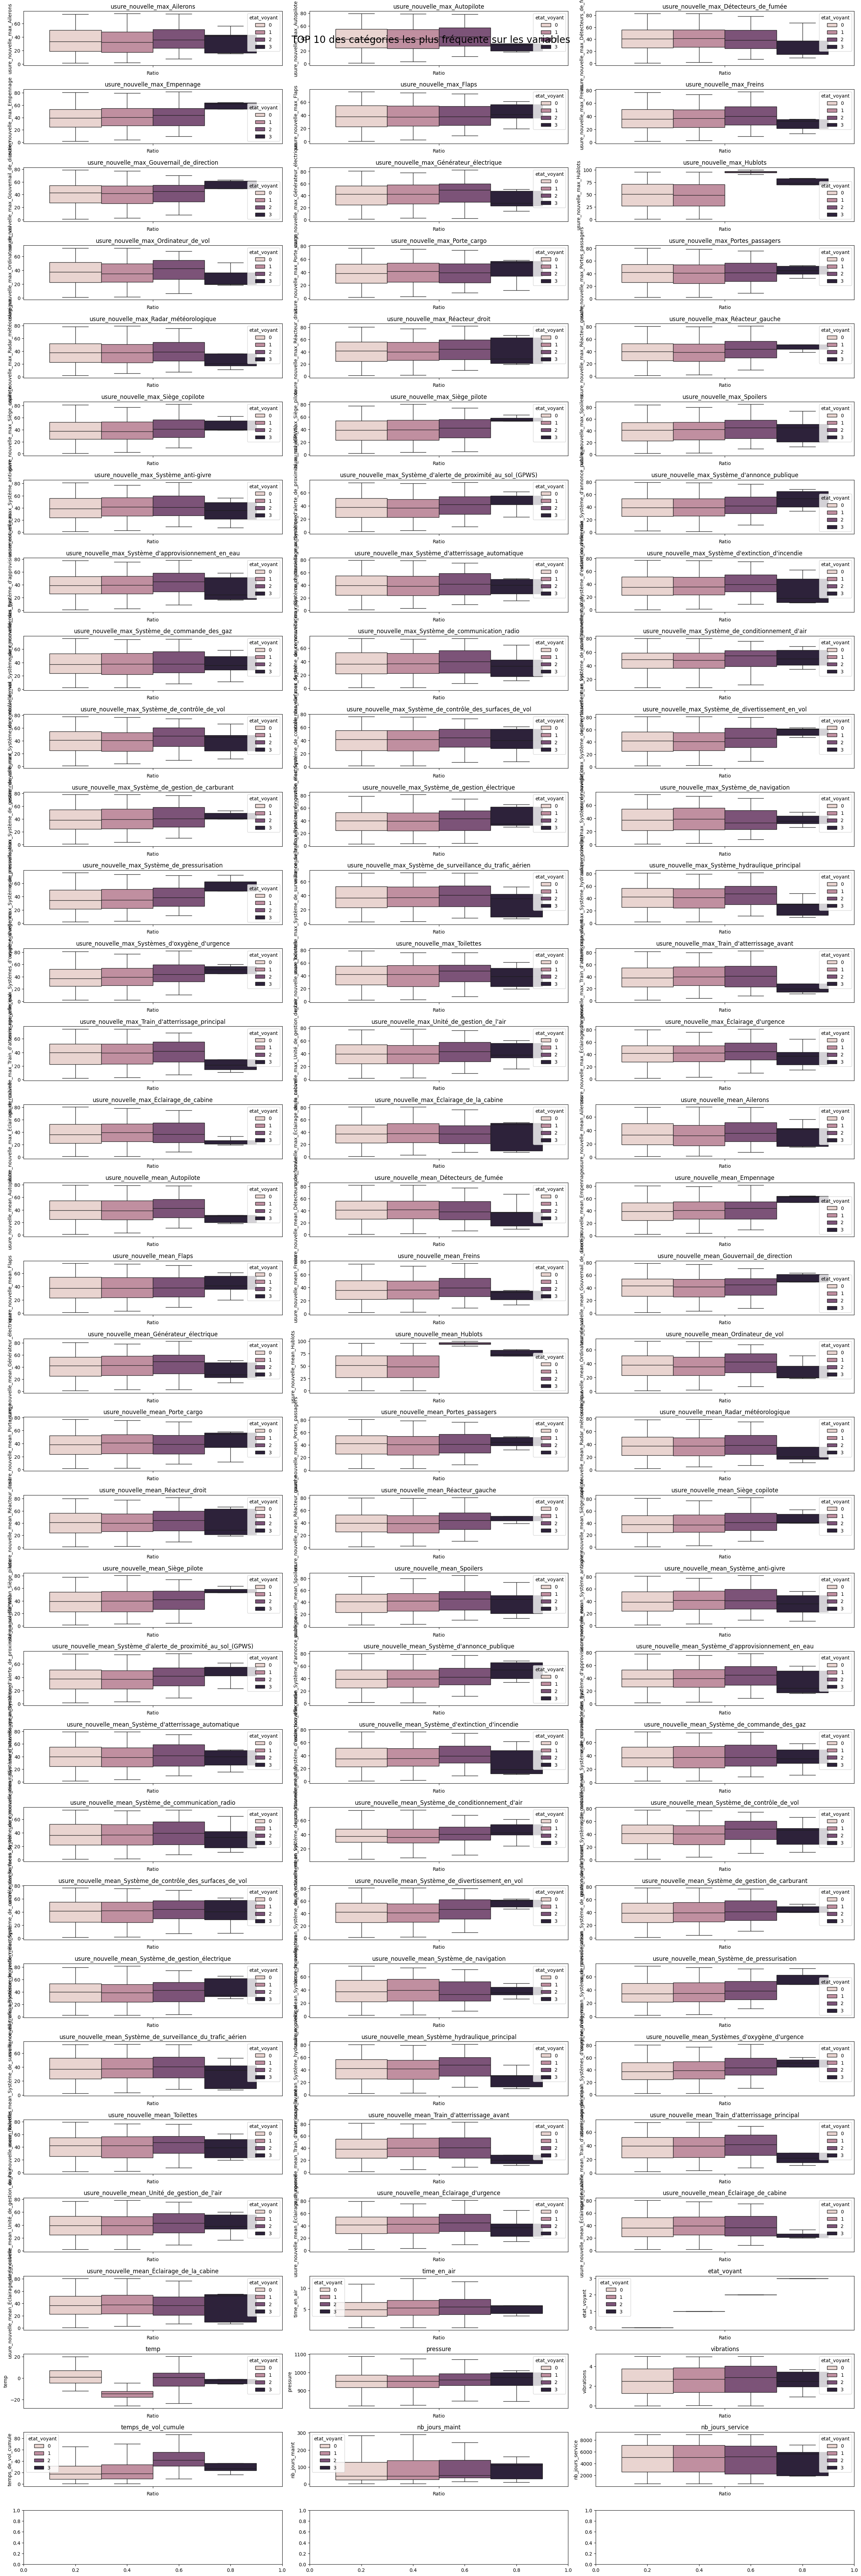

In [13]:
df_num = df.select_dtypes('number')

# Créer une figure avec des sous-graphiques
fig, axes = plt.subplots(33, 3, figsize=(25, 75))
fig.suptitle('TOP 10 des catégories les plus fréquente sur les variables', fontsize=20)
fig.tight_layout(pad=3.0)

# Parcourir chaque colonne et créer un histogramme
for i, col in enumerate(df_num.columns):
    

    sns.boxplot(data=df, y=col,  ax=axes[i//3, i%3], hue='etat_voyant', showfliers= False)
    axes[i//3, i%3].set_title(col)
    axes[i//3, i%3].set_xlabel('Ratio')
    axes[i//3, i%3].set_ylabel(col)

plt.tight_layout()
plt.show()

In [14]:
# fig_correl, ax_correl = plt.subplots(1,1, figsize = (20,10))

# numerical_corr_matrix = df.select_dtypes(include='number').corr()

# mask = np.triu(np.ones_like(numerical_corr_matrix, dtype=bool))

# annot_kwargs = {
#     "fontsize": 12
# }

# sns.heatmap(numerical_corr_matrix,
#                 center= 0,
#                 cmap = sns.color_palette("vlag", as_cmap=True),
#                 annot= True,
#                 mask= mask,
#                 ax=ax_correl,
#                 linewidths=.5,
#                 fmt= '.2f',
#                 annot_kws= annot_kwargs
#                 )

# ax_correl.set_title('Matrice de corrélation pour Voyant tous les voyants', fontsize= 15)
# ax_correl.set_xticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 40)
# ax_correl.set_yticklabels(ax_correl.get_xticklabels(), fontsize=10, rotation = 0)

# plt.show(fig_correl.figure)

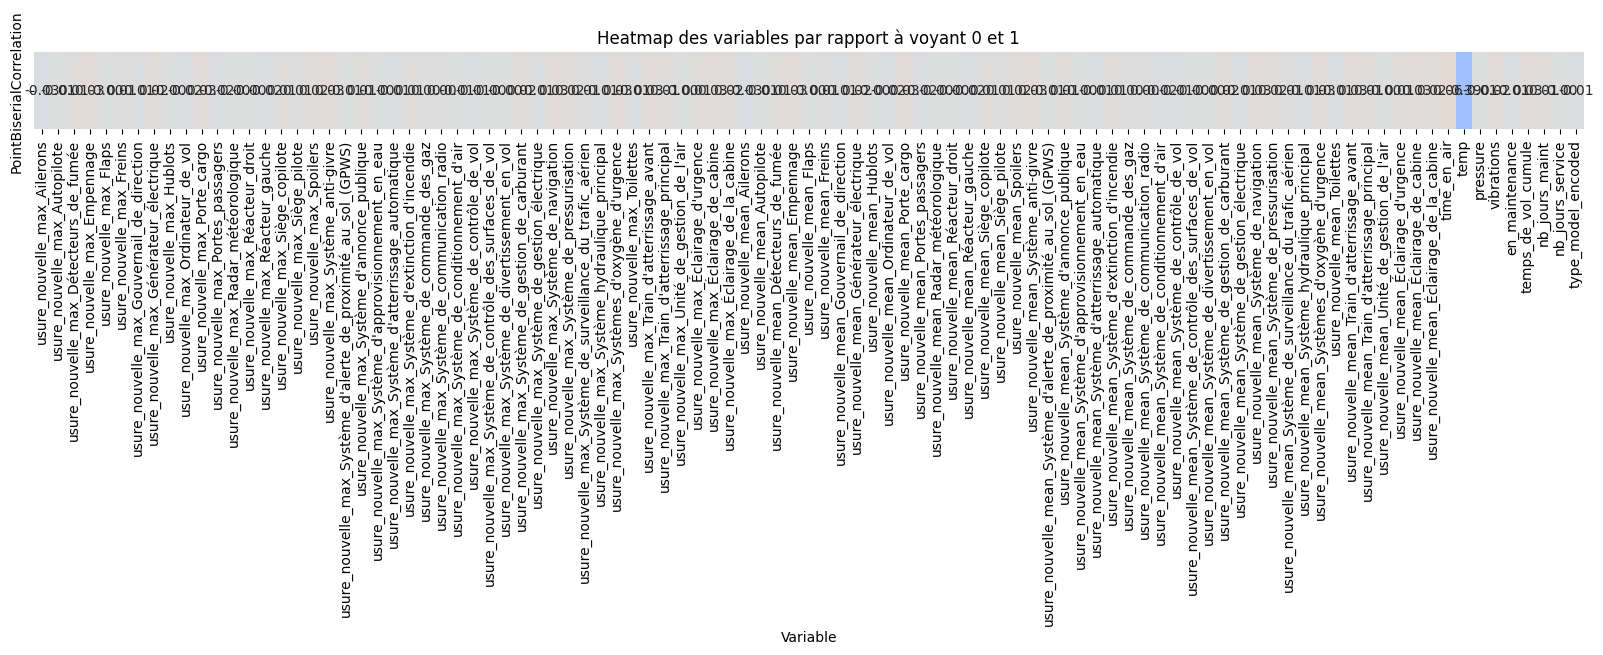

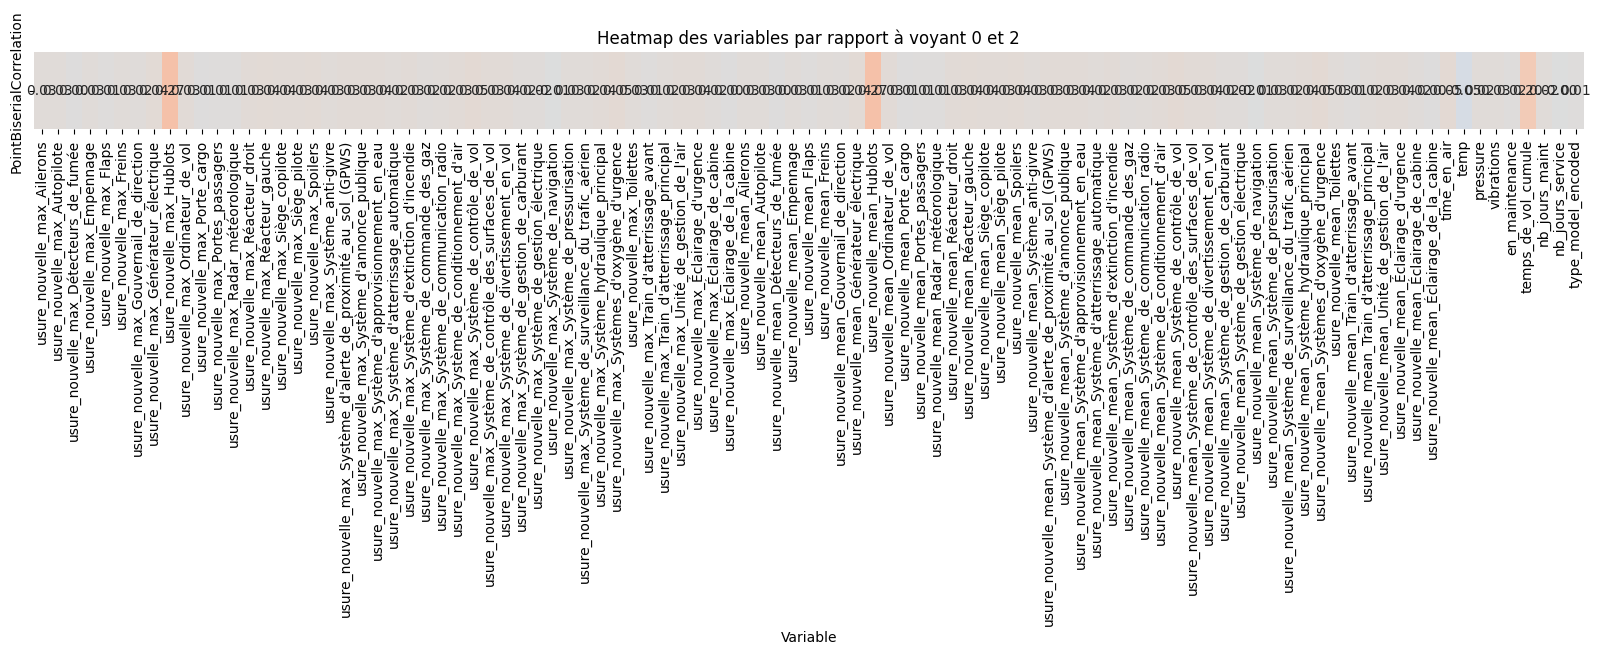

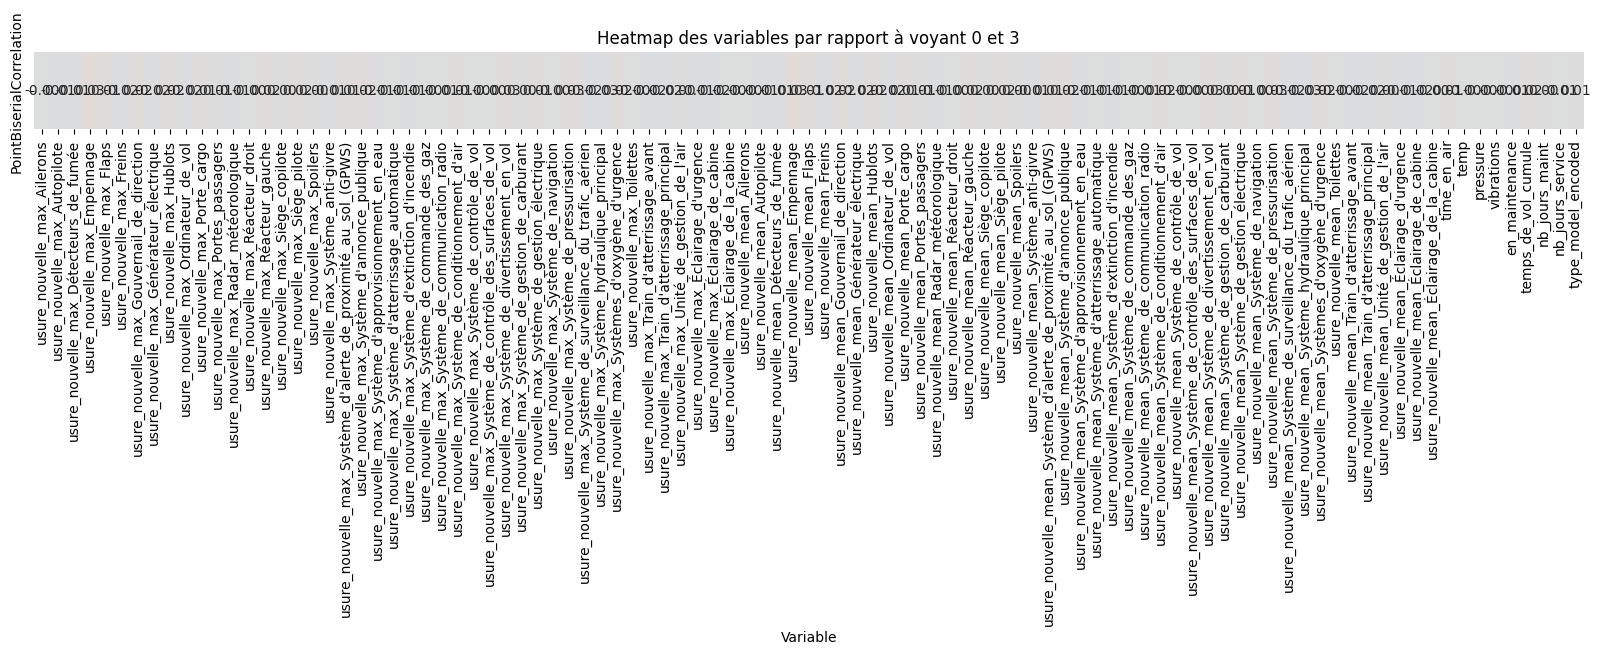

In [15]:
# encodage 0 ou 1 pour la class etat_voyant trié à 3

label_encoder = LabelEncoder()

for i in range(0,4,1):
    if i!=0:

        df_3 = df[(df['etat_voyant']==i) | (df['etat_voyant']==0)].copy()

        df_3['etat_voyant_encoded'] = label_encoder.fit_transform(df_3['etat_voyant'])
        df_3['type_model_encoded'] = label_encoder.fit_transform(df_3['type_model'])

        df_3.drop(['etat_voyant', 'type_model', 'measure_day_'], axis=1, inplace=True)

        continuous_cols = df_3.drop(columns=['etat_voyant_encoded', 'aero_' ])

        # Calculer la corrélation bisériale ponctuelle pour chaque variable continue
        correlations = {}

        for col in continuous_cols.columns:

            correlations[col] = pointbiserialr(df_3['etat_voyant_encoded'], df_3[col])[0]


        # Convertir le dictionnaire en DataFrame pour la heatmap
        corr_df = pd.DataFrame(list(correlations.items()), columns=['Variable', 'PointBiserialCorrelation'])
        corr_df.set_index('Variable', inplace=True)


        plt.figure(figsize=(20, 1))
        sns.heatmap(corr_df.T, annot=True, cmap='coolwarm', cbar=False, fmt=".2f", vmin=-1, vmax= 1)
        plt.title(f'Heatmap des variables par rapport à voyant {0} et {i}')


        plt.show()

# 2- Prepa des données et pipeline pour ML

In [16]:
df.select_dtypes(exclude='number').columns


Index(['aero_', 'measure_day_', 'type_model', 'en_maintenance'], dtype='object')

In [17]:
features_std = [
'usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service'
]

features_oneHot = ['type_model']


features_binar =['en_maintenance']

In [18]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

In [19]:
y = df['etat_voyant'] 

X = df[['usure_nouvelle_max_Ailerons', 
'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]]

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify = y)

# 3- Essai de modele

## 3.1- Logistic regression

In [21]:
RL_model = XGBClassifier()

In [22]:
pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=3, random_state=42)),
    ('model', RL_model)
])

In [23]:
param_dist_xgbc = {
    'model__n_estimators': [50, 100, 200, 300, 400, 500],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3, 0.4],
    'model__max_depth': [3, 4, 5, 6, 7, 8, 9, 10],
    'model__subsample': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bytree': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bylevel': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__colsample_bynode': [0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
    'model__gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5],
    'model__min_child_weight': [1, 2, 3, 4, 5, 6],
    'model__reg_alpha': [0, 0.01, 0.1, 1, 10],
    'model__reg_lambda': [1, 0.1, 0.01, 0.001, 0],
    'model__eval_metric': ['mlogloss', 'logloss'],
}


In [24]:
random_search_xgbc = RandomizedSearchCV(
    estimator=pipeline_reg_log,
    param_distributions=param_dist_xgbc,
    n_iter=50,  
    scoring='accuracy',
    verbose=1,
    random_state=42,
    cv=5,
    n_jobs=-1  
)

{'recall_micro', 'neg_mean_absolute_error', 'jaccard_micro', 'neg_root_mean_squared_error', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'balanced_accuracy', 'neg_mean_squared_log_error', 'f1_weighted', 'roc_auc', 'neg_mean_squared_error', 'explained_variance', 'r2', 'recall', 'recall_weighted', 'completeness_score', 'precision_macro', 'neg_brier_score', 'precision', 'neg_mean_gamma_deviance', 'f1_samples', 'f1_macro', 'homogeneity_score', 'recall_samples', 'd2_absolute_error_score', 'v_measure_score', 'precision_samples', 'accuracy', 'roc_auc_ovo_weighted', 'max_error', 'adjusted_mutual_info_score', 'neg_root_mean_squared_log_error', 'jaccard_weighted', 'jaccard_samples', 'positive_likelihood_ratio', 'neg_mean_poisson_deviance', 'neg_negative_likelihood_ratio', 'roc_auc_ovr', 'average_precision', 'precision_weighted', 'neg_mean_absolute_percentage_error', 'neg_median_absolute_error', 'precision_micro', 'neg_log_loss', 'f1', 'matthews_corrcoef', 'rand_score', 'fowlkes_mallows_score', 'jaccard', 'normalized_mutual_info_score', 'top_k_accuracy', 'adjusted_rand_score', 'jaccard_macro', 'f1_micro', 'mutual_info_score', 'recall_macro'}

In [25]:
random_search_xgbc.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits


c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 4 members, which is less than n_splits=5.
  warnings.warn(
c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_validation.py:540: FitFailedWarning: 
200 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
200 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\dimle\Documents\clone_repo\preventive_maintenance\.conda\Lib\site-packages\sklearn\model_selection\_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fi

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num_std',
                                                                               Pipeline(steps=[('stdScaller',
                                                                                                StandardScaler())]),
                                                                               ['usure_nouvelle_max_Ailerons',
                                                                                'usure_nouvelle_max_Autopilote',
                                                                                'usure_nouvelle_max_Détecteurs_de_fumée',
                                                                                'usure_nouvelle_max_Empennage',
                                                                                'usure_nouvelle_max_Flaps',
                                                                                'usure_nouvelle_max_Freins',
                                                                                '...
                                                         0.5],
                                        'model__learning_rate': [0.01, 0.05,
                                                                 0.1, 0.2, 0.3,
                                                                 0.4],
                                        'model__max_depth': [3, 4, 5, 6, 7, 8,
                                                             9, 10],
                                        'model__min_child_weight': [1, 2, 3, 4,
                                                                    5, 6],
                                        'model__n_estimators': [50, 100, 200,
                                                                300, 400, 500],
                                        'model__reg_alpha': [0, 0.01, 0.1, 1,
                                                             10],
                                        'model__reg_lambda': [1, 0.1, 0.01,
                                                              0.001, 0],
                                        'model__subsample': [0.5, 0.6, 0.7, 0.8,
                                                             0.9, 1.0]},
                   random_state=42, scoring='accuracy', verbose=1)

In [26]:
# Afficher les meilleurs paramètres trouvés
print("Best parameters found: ", random_search_xgbc.best_params_)

# Évaluer le modèle sur l'ensemble de test
best_model_xgbc = random_search_xgbc.best_estimator_

Best parameters found:  {'model__subsample': 0.7, 'model__reg_lambda': 0.1, 'model__reg_alpha': 0.1, 'model__n_estimators': 300, 'model__min_child_weight': 5, 'model__max_depth': 9, 'model__learning_rate': 0.2, 'model__gamma': 0.5, 'model__eval_metric': 'logloss', 'model__colsample_bytree': 0.8, 'model__colsample_bynode': 0.9, 'model__colsample_bylevel': 0.9}


In [27]:
y_pred_rl = best_model_xgbc.predict(X_test)

In [28]:
accuracy_rl = accuracy_score(y_test, y_pred_rl)

print(f'Accuracy: {accuracy_rl:.4f}')

Accuracy: 0.9716


In [29]:
class_report_rl = classification_report(y_test, y_pred_rl)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98      1097
           1       0.89      0.95      0.92       176
           2       0.82      0.93      0.88        30
           3       0.00      0.00      0.00         1

    accuracy                           0.97      1304
   macro avg       0.68      0.72      0.70      1304
weighted avg       0.97      0.97      0.97      1304



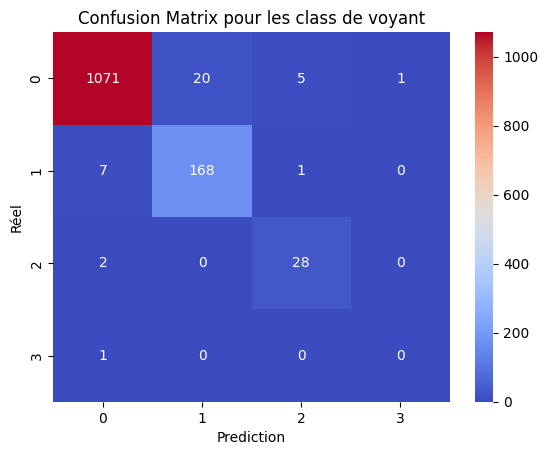

In [30]:
conf_matrix_rl = confusion_matrix(y_test, y_pred_rl)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix pour les class de voyant')
plt.show()

# 3- Enregistrement du modele

In [31]:

# Enregistrer le modèle dans un fichier
joblib.dump(best_model_xgbc, 'best_model_avion_full_compo.pkl')

['best_model_avion_full_compo.pkl']

# 4- Essai de modele avec serie temporelle

In [32]:
liste_pour_lag = [      
       'usure_nouvelle_max_Ailerons', 
       'usure_nouvelle_max_Autopilote',
       'usure_nouvelle_max_Détecteurs_de_fumée',
       'usure_nouvelle_max_Empennage', 
       'usure_nouvelle_max_Flaps',
       'usure_nouvelle_max_Freins',
       'usure_nouvelle_max_Gouvernail_de_direction',
       'usure_nouvelle_max_Générateur_électrique',
       'usure_nouvelle_max_Hublots', 
       'usure_nouvelle_max_Ordinateur_de_vol',
       'usure_nouvelle_max_Porte_cargo', 
       'usure_nouvelle_max_Portes_passagers',
       'usure_nouvelle_max_Radar_météorologique',
       'usure_nouvelle_max_Réacteur_droit',
       'usure_nouvelle_max_Réacteur_gauche',
       'usure_nouvelle_max_Siège_copilote', 
       'usure_nouvelle_max_Siège_pilote',
       'usure_nouvelle_max_Spoilers', 
       'usure_nouvelle_max_Système_anti-givre',
       'usure_nouvelle_max_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_max_Système_d\'annonce_publique',
       'usure_nouvelle_max_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_max_Système_d\'atterrissage_automatique',
       'usure_nouvelle_max_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_max_Système_de_commande_des_gaz',
       'usure_nouvelle_max_Système_de_communication_radio',
       'usure_nouvelle_max_Système_de_conditionnement_d\'air',
       'usure_nouvelle_max_Système_de_contrôle_de_vol',
       'usure_nouvelle_max_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_max_Système_de_divertissement_en_vol',
       'usure_nouvelle_max_Système_de_gestion_de_carburant',
       'usure_nouvelle_max_Système_de_gestion_électrique',
       'usure_nouvelle_max_Système_de_navigation',
       'usure_nouvelle_max_Système_de_pressurisation',
       'usure_nouvelle_max_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_max_Système_hydraulique_principal',
       'usure_nouvelle_max_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_max_Toilettes',
       'usure_nouvelle_max_Train_d\'atterrissage_avant',
       'usure_nouvelle_max_Train_d\'atterrissage_principal',
       'usure_nouvelle_max_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_max_Éclairage_d\'urgence',
       'usure_nouvelle_max_Éclairage_de_cabine',
       'usure_nouvelle_max_Éclairage_de_la_cabine',
       'usure_nouvelle_mean_Ailerons', 
       'usure_nouvelle_mean_Autopilote',
       'usure_nouvelle_mean_Détecteurs_de_fumée',
       'usure_nouvelle_mean_Empennage', 
       'usure_nouvelle_mean_Flaps',
       'usure_nouvelle_mean_Freins',
       'usure_nouvelle_mean_Gouvernail_de_direction',
       'usure_nouvelle_mean_Générateur_électrique',
       'usure_nouvelle_mean_Hublots', 
       'usure_nouvelle_mean_Ordinateur_de_vol',
       'usure_nouvelle_mean_Porte_cargo',
       'usure_nouvelle_mean_Portes_passagers',
       'usure_nouvelle_mean_Radar_météorologique',
       'usure_nouvelle_mean_Réacteur_droit',
       'usure_nouvelle_mean_Réacteur_gauche',
       'usure_nouvelle_mean_Siège_copilote',
       'usure_nouvelle_mean_Siège_pilote', 
       'usure_nouvelle_mean_Spoilers',
       'usure_nouvelle_mean_Système_anti-givre',
       'usure_nouvelle_mean_Système_d\'alerte_de_proximité_au_sol_(GPWS)',
       'usure_nouvelle_mean_Système_d\'annonce_publique',
       'usure_nouvelle_mean_Système_d\'approvisionnement_en_eau',
       'usure_nouvelle_mean_Système_d\'atterrissage_automatique',
       'usure_nouvelle_mean_Système_d\'extinction_d\'incendie',
       'usure_nouvelle_mean_Système_de_commande_des_gaz',
       'usure_nouvelle_mean_Système_de_communication_radio',
       'usure_nouvelle_mean_Système_de_conditionnement_d\'air',
       'usure_nouvelle_mean_Système_de_contrôle_de_vol',
       'usure_nouvelle_mean_Système_de_contrôle_des_surfaces_de_vol',
       'usure_nouvelle_mean_Système_de_divertissement_en_vol',
       'usure_nouvelle_mean_Système_de_gestion_de_carburant',
       'usure_nouvelle_mean_Système_de_gestion_électrique',
       'usure_nouvelle_mean_Système_de_navigation',
       'usure_nouvelle_mean_Système_de_pressurisation',
       'usure_nouvelle_mean_Système_de_surveillance_du_trafic_aérien',
       'usure_nouvelle_mean_Système_hydraulique_principal',
       'usure_nouvelle_mean_Systèmes_d\'oxygène_d\'urgence',
       'usure_nouvelle_mean_Toilettes',
       'usure_nouvelle_mean_Train_d\'atterrissage_avant',
       'usure_nouvelle_mean_Train_d\'atterrissage_principal',
       'usure_nouvelle_mean_Unité_de_gestion_de_l\'air',
       'usure_nouvelle_mean_Éclairage_d\'urgence',
       'usure_nouvelle_mean_Éclairage_de_cabine',
       'usure_nouvelle_mean_Éclairage_de_la_cabine', 
       'time_en_air',
       'temp', 
       'pressure', 
       'vibrations', 
       'temps_de_vol_cumule',
       'nb_jours_maint', 
       'nb_jours_service',
       'type_model',
       'en_maintenance'
       ]


In [33]:
# Création des valeurs décalées (lagged values)
for var in liste_pour_lag:

    for lag in range(1, 2):

        df[f'{var}_lag_{lag}'] = df[var].shift(lag)


C:\Users\dimle\AppData\Local\Temp\ipykernel_30536\1925781627.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_30536\1925781627.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f'{var}_lag_{lag}'] = df[var].shift(lag)
C:\Users\dimle\AppData\Local\Temp\ipykernel_30536\1925781627.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consid

In [34]:
list_drop = []
for i in df.columns:

    if i in X.columns:
        pass
    else:
        list_drop.append(i)

In [35]:

# Suppression des lignes avec des valeurs manquantes dues aux décalages
df = df.dropna()

X=df

# Séparation des caractéristiques et de la cible
y = df['etat_voyant'] 


In [36]:
# Division en ensembles d'entraînement et de test
split_date = datetime(2024, 7, 19)

# ajuster en fonction de votre dataset
X_train = X[df['measure_day_'] < split_date]
X_test = X[df['measure_day_'] >= split_date]
y_train = y[df['measure_day_'] < split_date]
y_test = y[df['measure_day_'] >= split_date]


In [37]:
# X_train = X_train.drop(['measure_day_'], axis=1)
# X_test = X_test.drop(['measure_day_'], axis=1)



X = df.drop(list_drop, axis=1)

In [38]:
# Entraînement du modèle
RL_model = XGBClassifier()


In [39]:
# Préparation des transformateurs pour les caractéristiques numériques
numeric_transformer_std = (ImbPipeline( steps= [
    ('stdScaller', StandardScaler())
]))

categ_transformer_onehot = (ImbPipeline( steps= [
    ('OneHot', OneHotEncoder())
]))

categ_transformer_bin = (ImbPipeline( steps= [
    ('bina', OrdinalEncoder())
]))


# Combinaison des transformation pour le preprocessing
preprocessor = ColumnTransformer(
    transformers= [
        ('num_std', numeric_transformer_std, features_std),
        ('cat_oneHot', categ_transformer_onehot, features_oneHot),
        ('cat_bin', categ_transformer_bin, features_binar)
    ]
)

pipeline_reg_log = ImbPipeline(steps=[
    ('preprocessor', preprocessor),
    ('smote', SMOTE(k_neighbors=1, random_state=42)),
    ('model', RL_model)
])


In [40]:
pipeline_reg_log.fit(X_train, y_train)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num_std',
                                                  Pipeline(steps=[('stdScaller',
                                                                   StandardScaler())]),
                                                  ['usure_nouvelle_max_Ailerons',
                                                   'usure_nouvelle_max_Autopilote',
                                                   'usure_nouvelle_max_Détecteurs_de_fumée',
                                                   'usure_nouvelle_max_Empennage',
                                                   'usure_nouvelle_max_Flaps',
                                                   'usure_nouvelle_max_Freins',
                                                   'usure_nouvelle_max_Gouvernail_de_d...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None,
                               objective='multi:softprob', ...))])

In [41]:
# Prédiction et évaluation
y_pred = pipeline_reg_log.predict(X_test)

In [42]:
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.2f}')

Accuracy: 0.98


In [43]:
class_report_rl = classification_report(y_test, y_pred)

print(class_report_rl)

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       591
           1       0.98      0.94      0.96       106
           2       0.83      0.80      0.82        25

    accuracy                           0.98       722
   macro avg       0.93      0.91      0.92       722
weighted avg       0.98      0.98      0.98       722



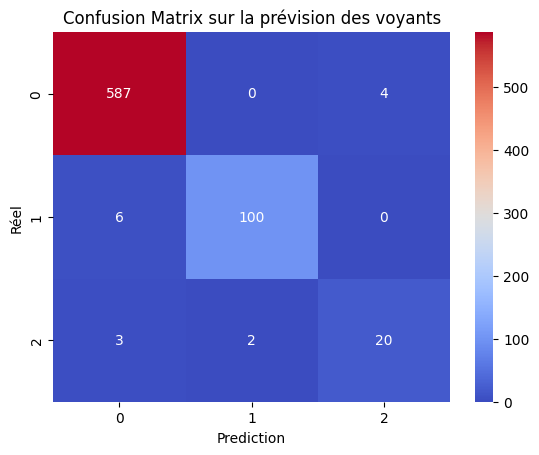

In [44]:
conf_matrix_rl = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix_rl, annot=True, fmt='d', cmap='coolwarm')
plt.xlabel('Prediction')
plt.ylabel('Réel')

plt.title('Confusion Matrix sur la prévision des voyants')
plt.show()